In [20]:
from analyze import *
import os

# path to your datafolder of choice
data_folder_path = "/home/robinferede/Git/analyze_flight_data/flight_data"
# symbolic link to /flight_data
if not os.path.exists("flight_data"):
    os.symlink(data_folder_path, "flight_data")

# look through flight_data folder for files containing "aug" (lowercase or uppercase)
# and print out the file names with numbers
files = [f for f in os.listdir("flight_data") if "okt10" in f.lower() or "sepaa" in f.lower()]
for i, f in enumerate(files):
    print(i, f)

0 Okt10_NN_long_oval_1.csv
1 Okt10_NN_long_oval_3.csv
2 Okt10_NN_long_oval_4.csv
3 Okt10_NN_long_oval_2.csv
4 Okt10_LongOval_TT_160.csv


In [21]:
path = 'flight_data/Okt10_NN_long_oval_2.csv'
data = load_flight_data(path)
data = trim_nn_active(data)
data = trim_time(data, 0, 10)

# trim data from t=3 to t=5

Loading flight_data/Okt10_NN_long_oval_2.csv
Logging frequency: 808.4233029186809


In [22]:
opti_indices = [i for i in range(len(data['t'])-1) if data['x_opti'][i]!=data['x_opti'][i+1]]
opti_time = data['t'][opti_indices]
print('opti freq:', 1/np.mean(np.diff(opti_time)))

opti freq: 18.406170472519587


In [23]:
# reload analyze
import importlib
import analyze
importlib.reload(analyze)


# animate
# race track
# r = 1.5
# gate_pos = np.array([
#     [ r,  -r, -1.5],
#     [ 0,   0, -1.5],
#     [-r,   r, -1.5],
#     [ 0, 2*r, -1.5],
#     [ r,   r, -1.5],
#     [ 0,   0, -1.5],
#     [-r,  -r, -1.5],
#     [ 0,-2*r, -1.5]
# ])
# gate_yaw = np.array([1,2,1,0,-1,-2,-1,0])*np.pi/2

# long oval
gate_pos = np.array([
    [1.5, -5., -1.5],
    [1.5,  5., -1.5],
    [0.0, 6.5, -1.5],
    [-1.5, 5., -1.5],
    [-1.5, -5., -1.5],
    [0.0, -6.5, -1.5]
])
gate_yaw = np.array([0, 0, 0.5, 1, 1, 1.5])*np.pi+np.pi/2

animate_data_multiple2(data, gate_pos=gate_pos, gate_yaw=gate_yaw)

QObject::moveToThread: Current thread (0x60e3d0f60e70) is not the object's thread (0x60e3cf19dd80).
Cannot move to target thread (0x60e3d0f60e70)

QObject::moveToThread: Current thread (0x60e3d0f60e70) is not the object's thread (0x60e3cf19dd80).
Cannot move to target thread (0x60e3d0f60e70)

QObject::moveToThread: Current thread (0x60e3d0f60e70) is not the object's thread (0x60e3cf19dd80).
Cannot move to target thread (0x60e3d0f60e70)

QObject::moveToThread: Current thread (0x60e3d0f60e70) is not the object's thread (0x60e3cf19dd80).
Cannot move to target thread (0x60e3d0f60e70)

QObject::moveToThread: Current thread (0x60e3d0f60e70) is not the object's thread (0x60e3cf19dd80).
Cannot move to target thread (0x60e3d0f60e70)

QObject::moveToThread: Current thread (0x60e3d0f60e70) is not the object's thread (0x60e3cf19dd80).
Cannot move to target thread (0x60e3d0f60e70)

QObject::moveToThread: Current thread (0x60e3d0f60e70) is not the object's thread (0x60e3cf19dd80).
Cannot move to tar

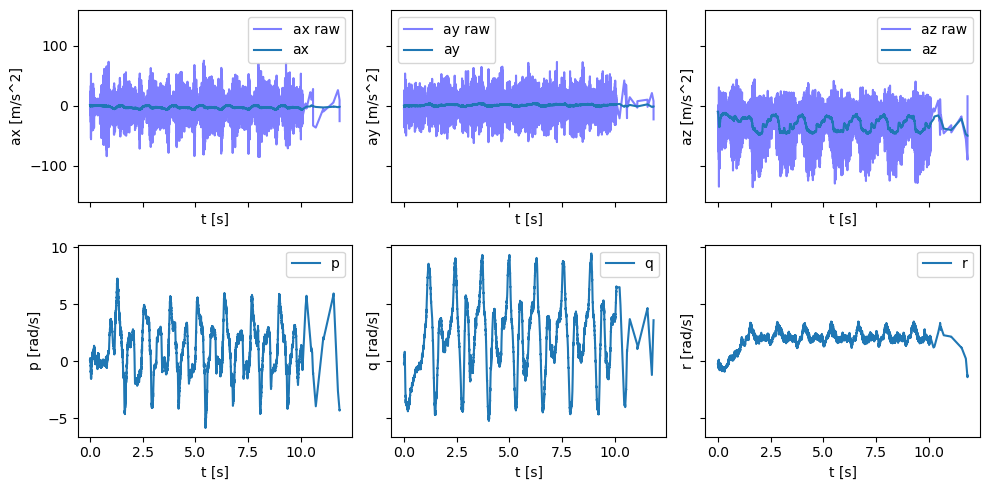

In [15]:
imu_plot(data)

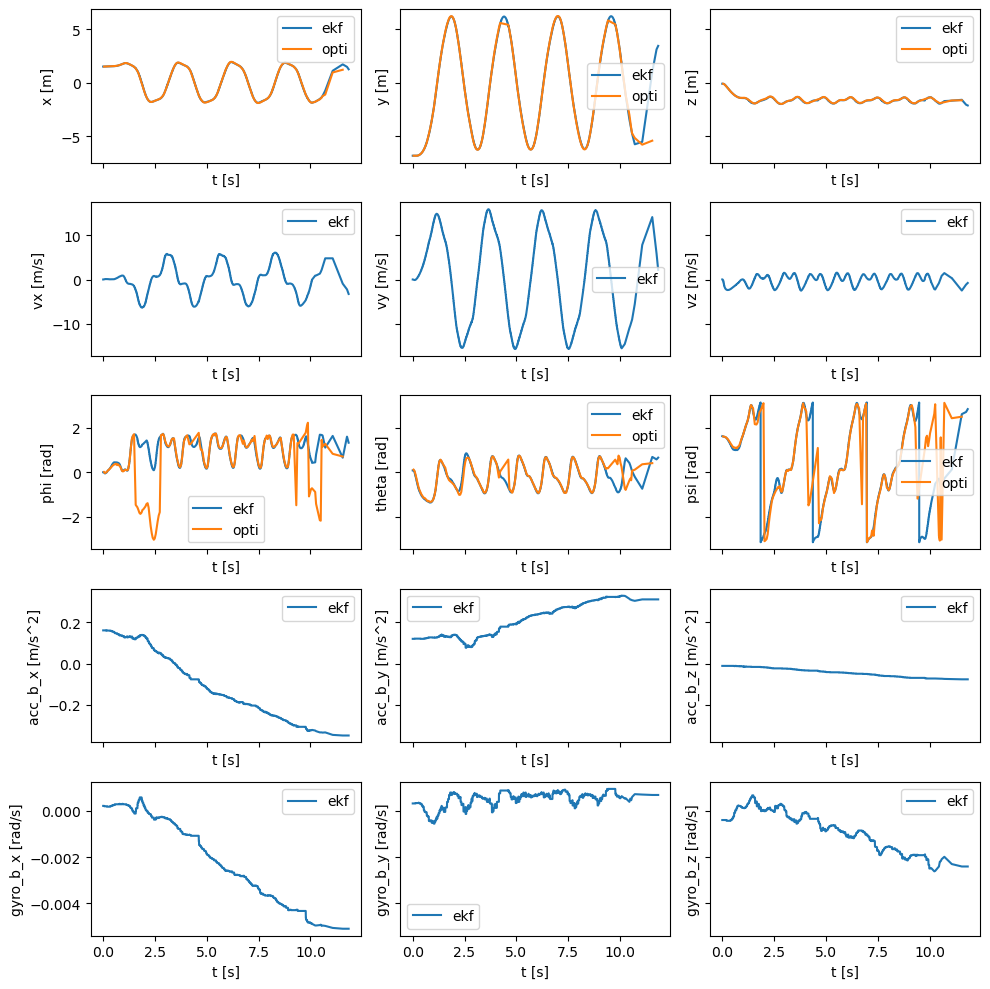

In [16]:
# NOT INLINE
ekf_plot(data)

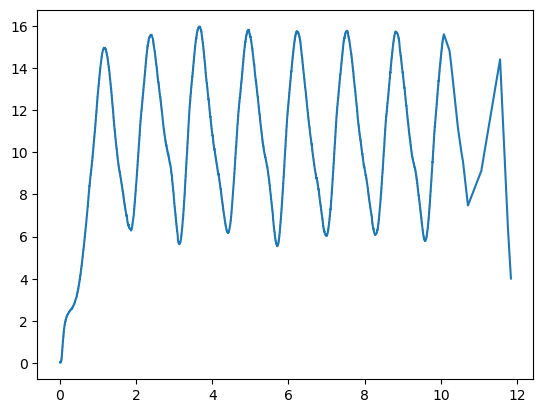

In [5]:
plt.plot(data['t'], data['v'])

fitting thrust and drag model


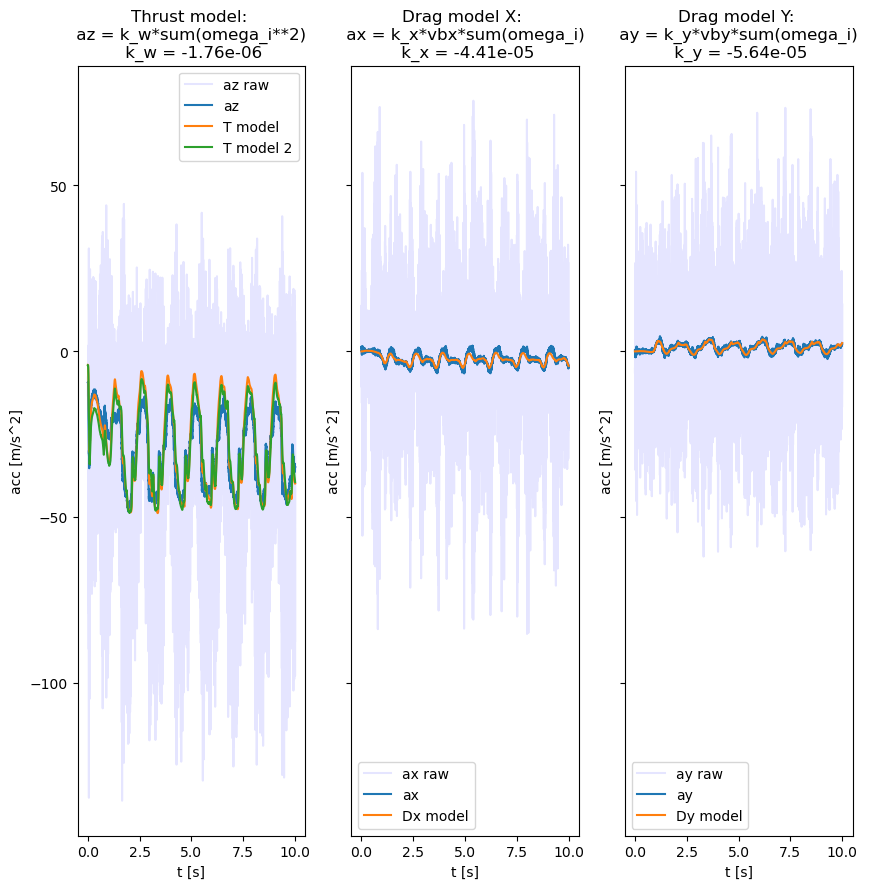

(np.float64(-1.760787661495768e-06),
 np.float64(-4.4101352886986136e-05),
 np.float64(-5.637960835110806e-05))